# 实现保留目标区域内的内容，区域外的全涂白,俗称Cartopy的白化

# 实现保留目标区域内的内容，区域外的全涂白,俗称Cartopy的白化

In [1]:
# 导入需要用到的包
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import geopandas as gpd
from cartopy.io.shapereader import Reader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
###
import xarray as xr
### 白化关键包
from matplotlib.path import Path
from cartopy.mpl.patch import geos_to_path

In [2]:
# 读取地图shp文件，以广西为例
shp= gpd.read_file('D:\\maplist\\province\\450000_full.shp',encoding='UTF-8')
shp

,adcode,name,center,centroid,childrenNu,level,parent,subFeature,acroutes,geometry
0,450100,南宁市,None,None,12,city,None,0,None,"POLYGON ((109.21702 23.29683, 109.22082 23.290..."
1,450200,柳州市,None,None,10,city,None,1,None,"POLYGON ((110.11620 24.46083, 110.09740 24.462..."
2,450300,桂林市,None,None,17,city,None,2,None,"POLYGON ((111.09744 24.94089, 111.09774 24.931..."
3,450400,梧州市,None,None,7,city,None,3,None,"POLYGON ((110.39190 24.04216, 110.40004 24.048..."
4,450500,北海市,None,None,4,city,None,4,None,"MULTIPOLYGON (((109.60765 21.90887, 109.61976 ..."
5,450600,防城港市,None,None,4,city,None,5,None,"POLYGON ((108.09588 22.37167, 108.10493 22.355..."
6,450700,钦州市,None,None,4,city,None,6,None,"MULTIPOLYGON (((109.60765 21.90887, 109.59418 ..."
7,450800,贵港市,None,None,5,city,None,7,None,"POLYGON ((109.66223 22.66237, 109.65158 22.668..."
8,450900,玉林市,None,None,7,city,None,8,None,"POLYGON ((109.66223 22.66237, 109.67319 22.676..."
9,451000,百色市,None,None,12,city,None,9,None,"MULTIPOLYGON (((106.57116 25.08350, 106.57839 ..."


In [3]:
ds=xr.open_dataset(r"D:\DATA\adata\2020-4-17.nc")
ds

<xarray.Dataset>
Dimensions:    (longitude: 241, latitude: 241, level: 27, time: 1)
Coordinates:
  * longitude  (longitude) float32 70.0 70.25 70.5 70.75 ... 129.5 129.8 130.0
  * latitude   (latitude) float32 60.0 59.75 59.5 59.25 ... 0.75 0.5 0.25 0.0
  * level      (level) int32 100 125 150 175 200 225 ... 900 925 950 975 1000
  * time       (time) datetime64[ns] 2020-04-17T12:00:00
Data variables:
    d          (time, level, latitude, longitude) float32 ...
    z          (time, level, latitude, longitude) float32 ...
    t          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-04-17 05:47:25 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...

In [4]:
# 读取1000hPa的气温
t = ds['t'][0,:,:,:].loc[1000,:,:]
lon=t['longitude'].data
lat=t['latitude'].data

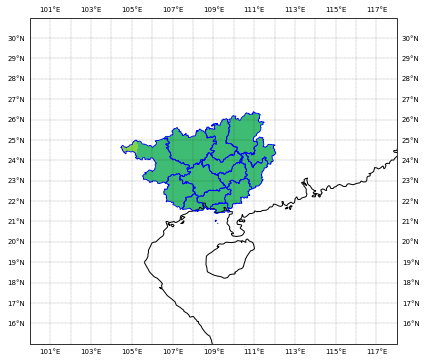

In [6]:
fig= plt.figure(figsize=(9,6))
ax=fig.subplots(1,1,subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines('50m')
# ax.add_feature(cfeature.RIVERS)
ax.add_geometries(Reader('D:\\maplist\\province\\450000_full.shp').geometries(),ccrs.PlateCarree(),facecolor='none', edgecolor='b', linewidth=0.8)
ax.set_extent([100,118,15,31])
colorbar=ax.contourf(lon,lat,t,transform=ccrs.PlateCarree())
# 坐标轴设置
tick = ax.gridlines(draw_labels=True, linestyle=':', linewidth=0.3, x_inline=False, y_inline=False, color='k')
tick.top_labels = True  ##打开上面的经纬度标签
tick.right_labels = True ###打开右边
tick.xformatter = LONGITUDE_FORMATTER
tick.yformatter = LATITUDE_FORMATTER
tick.xlocator = mticker.FixedLocator(np.arange(100, 118, 1))
tick.ylocator = mticker.FixedLocator(np.arange(15, 31, 1))
tick.xlabel_style = {'size': 7}
tick.ylabel_style = {'size': 7}
## 关键操作：生成裁剪路径
path_clip =Path.make_compound_path(*geos_to_path(shp['geometry'].to_list()))
## 关键操作：将裁剪路径应用到图层
for collection in colorbar.collections:
    collection.set_clip_path(path_clip,transform=ax.transData)

In [7]:
# 把多个shp文件的地理区域添加到白化区域中
##广西
shp= gpd.read_file('D:\\maplist\\province\\450000_full.shp',encoding='UTF-8')
##广东
shp1=gpd.read_file('D:\\maplist\\province\\440000_full.shp',encoding='UTF-8')
##湖南
shp2=gpd.read_file('D:\\maplist\\province\\430000_full.shp',encoding='UTF-8')
## 把这些数据添加到一个列表下即可
shplist=shp['geometry'].to_list()+shp1['geometry'].to_list()+shp2['geometry'].to_list()
shplist

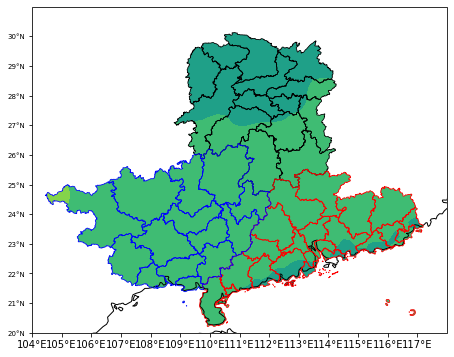

In [8]:
fig= plt.figure(figsize=(9,6))
ax=fig.subplots(1,1,subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines('50m')
# 经纬度格式，把0经度设置不加E和W
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.add_geometries(Reader('D:\\maplist\\province\\430000_full.shp').geometries(), ccrs.PlateCarree(),
                  facecolor='none', edgecolor='k', linewidth=0.8)##湖南
ax.add_geometries(Reader('D:\\maplist\\province\\440000_full.shp').geometries(), ccrs.PlateCarree(),
                  facecolor='none', edgecolor='r', linewidth=0.8)##广东
ax.add_geometries(Reader('D:\\maplist\\province\\450000_full.shp').geometries(), ccrs.PlateCarree(),
                  facecolor='none', edgecolor='b', linewidth=0.8)##广西
# 添加坐标轴
ax.set_xticks(np.arange(104, 118, 1), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(20, 31, 1), crs=ccrs.PlateCarree())
## 经纬度格式，把0经度设置不加E和W
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter(auto_hide=False)
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
# 设置刻度大小
ax.tick_params(axis='y',labelsize=7)
ax.tick_params(axis='x',labelsize=10)
# tick = ax.gridlines(draw_labels=True, linestyle=':', linewidth=0.3, x_inline=False, y_inline=False, color='k')
# tick.top_labels = True  ##打开上面的经纬度标签
# tick.right_labels = True ###打开右边
# tick.xformatter = LONGITUDE_FORMATTER
# tick.yformatter = LATITUDE_FORMATTER
# tick.xlocator = mticker.FixedLocator(np.arange(104, 118, 1))
# tick.ylocator = mticker.FixedLocator(np.arange(20, 31, 1))
# tick.xlabel_style = {'size': 7}
# tick.ylabel_style = {'size': 7}
ax.set_extent([104,118,20,31],ccrs.PlateCarree())
colorbar=ax.contourf(lon,lat,t,transform=ccrs.PlateCarree())

## 关键操作：生成裁剪路径
path_clip =Path.make_compound_path(*geos_to_path(shplist))
## 关键操作：将裁剪路径应用到图层
for collection in colorbar.collections:
    collection.set_clip_path(path_clip,transform=ax.transData)